In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/noise2noise

/content/drive/MyDrive/noise2noise


In [4]:
! git pull

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 5 (delta 3), reused 5 (delta 3), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/thurgarion2/noise2noise
   6db69d1..350d77f  master     -> origin/master
Updating 6db69d1..350d77f
Fast-forward
 Proj/Miniproject_2/model.py | 71 +++++++++++++++++++++++++++++++++++++++++----
 1 file changed, 65 insertions(+), 6 deletions(-)


In [3]:
! git config --global user.email "erwan.serandour@epfl.ch"
! git config --global user.name "thurgarion2"

In [ ]:
!git commit -am 'more tests'

[master 6db69d1] more tests
 6 files changed, 7 insertions(+), 1378 deletions(-)
 rewrite 00_augmentation.ipynb (99%)
 rewrite 00_helpers.ipynb (100%)
 rewrite _augmentation_test.ipynb (97%)
 rewrite _collab.ipynb (98%)
 rewrite _unet_and_batchnorm.ipynb (96%)


In [ ]:
%load_ext autoreload
%autoreload 2

In [5]:
!pip3 install -e . -q
!pip3 install nbdev -q

     |████████████████████████████████| 49 kB 5.0 MB/s 
     |████████████████████████████████| 561 kB 39.1 MB/s 
     |████████████████████████████████| 53 kB 2.5 MB/s 
     |████████████████████████████████| 60 kB 7.9 MB/s 
     |████████████████████████████████| 133 kB 60.2 MB/s 
     |████████████████████████████████| 130 kB 49.0 MB/s 
     |████████████████████████████████| 428 kB 57.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires tornado~=5.1.0; python_version >= "3.0", but you have tornado 6.1 which is incompatible.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.0.3 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [6]:
!nbdev_build_lib

Converted 00_augmentation.ipynb.
Converted 00_baseline.ipynb.
Converted 00_helpers.ipynb.
Converted 00_training.ipynb.
Converted 00_unet.ipynb.
Converted index.ipynb.


In [ ]:
from noise2noise.training import *
from noise2noise.unet import *
from noise2noise.helpers import *
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

training_img, training_target = load_images()
mean, std = to_float_image(training_img).mean(dim=(0,2,3)), to_float_image(training_img).std(dim=(0,2,3))
input_transform = transforms.Compose([ToFloatImage(), transforms.Normalize(mean =mean, std = std)])

target_transform = transforms.Compose([ToFloatImage()])

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


In [ ]:
train_loader =  DataLoader(
    Noise2NoiseDataset('./dataset/train_data.pkl', transform=input_transform, target_transform=target_transform),
    batch_size = 64,
    num_workers = 2,
    shuffle = True,
    pin_memory = torch.cuda.is_available()
)

test_loader =  DataLoader(
    Noise2NoiseDataset('./dataset/val_data.pkl', transform=input_transform, target_transform=target_transform),
    batch_size = 64,
    num_workers = 2,
    shuffle = True,
    pin_memory = torch.cuda.is_available()
)


/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)
 40%|████      | 400/1000 [00:19<00:21, 28.55it/s]Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
100%|██████████| 1000/1000 [00:40<00:00, 24.83it/s]


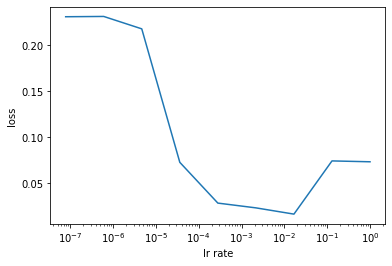

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


In [ ]:
unet = Unet().to(device)
metric = psnr_metric()
criterion = nn.MSELoss()

lr_finder(unet, train_loader, Adam, criterion, gradient_steps=1000, samples_steps=100)

In [ ]:
unet = Unet().to(device)
optim = Adam(unet.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.99)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, 1e-2, total_steps=1000)

metric = psnr_metric()
criterion = nn.MSELoss()




train_loss, test_loss, test_metric = train(unet, 
                                           train_loader, 
                                           test_loader, 
                                           optim, 
                                           criterion, 
                                           metric, 
                                           gradient_steps=2000, 
                                           samples_steps=100,
                                           lr_scheduler=scheduler,
                                           lr_steps=200)

  0%|          | 0/2000 [00:00<?, ?it/s]/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)
100%|██████████| 2000/2000 [03:19<00:00, 10.02it/s]


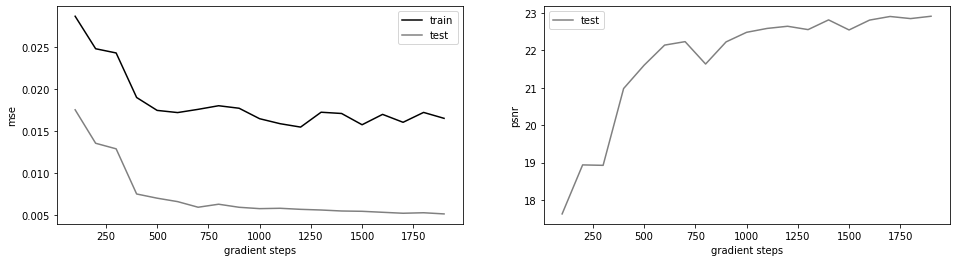

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


In [ ]:
plot_losses(train_loss, test_loss, test_metric)

psnr :23.436811447143555
psnr :21.81351089477539
psnr :25.711894989013672
psnr :20.587844848632812


/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


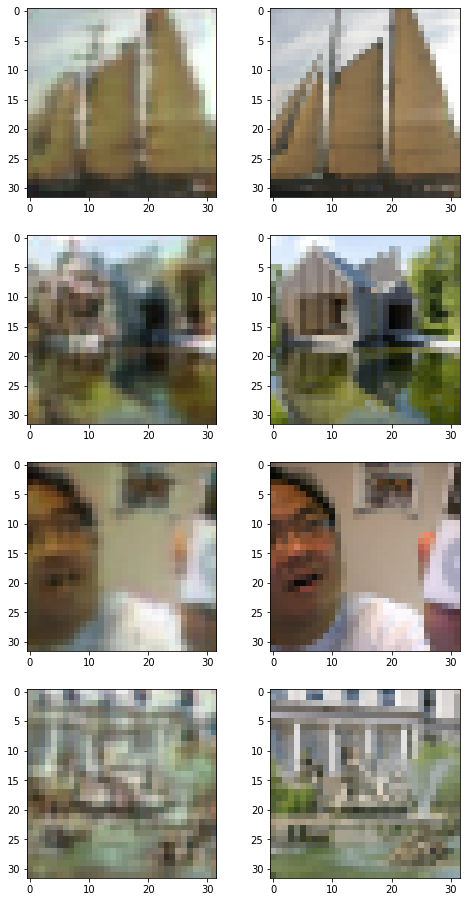

In [ ]:
show_results(unet, test_loader)